# Project 2: part1

## Import libraries

In [1]:
from pymonntorch import *
import torch

import matplotlib.pyplot as plt

from models.activity import ActivityRecorder
from models.dendrites import Dendrite
from models.currents import ConstantCurrent, NoisyCurrent, SetCurrent, StepFunction
from models.neurons import LIF
from models.synapses import SimpleSynapse, FullyConnectedSynapse, RandomConnectedFixedProbSynapse, \
    RandomConnectedFixedInputSynapse
from models.time_res import TimeResolution

In [2]:
def plot_neuron_activity(net, ng_name, title):

    fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True)

    # Plot the membrane potential(voltage)
    axs[0, 0].plot(net[f"{ng_name}_rec", 0].variables["u"][:, :])
    axs[0, 0].axhline(y=net.NeuronGroups[0].behavior[5].init_kwargs['threshold'], color='red', linestyle='--', label=f"{ng_name} Threshold")
    axs[0, 0].set_xlabel('t')
    axs[0, 0].set_ylabel('U(t)')
    axs[0, 0].set_title('Membrane Potential')

    # Plot the current
    axs[1, 0].plot(net[f"{ng_name}_rec", 0].variables["I"][:, :])
    axs[1, 0].set_xlabel('t')
    axs[1, 0].set_ylabel('I(t)')
    axs[1, 0].set_title('Current')

    # Plot the raster plot
    spike_events = net[f"{ng_name}_event", 0].variables["spike"]
    spike_times = spike_events[:, 0]
    neuron_ids = spike_events[:, 1]
    axs[0, 1].scatter(spike_times, neuron_ids, s=5)
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Neuron ID')
    axs[0, 1].set_title('Raster Plot for LIF model')

    # Plot the activity
    axs[1, 1].plot(net[f"{ng_name}_rec", 0].variables["activity"])
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('activity')
    axs[1, 1].set_title('Activity')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Part 1: Implementing synapses mechanism using delta dirac function
The delta dirac function has been implemented in synapses model, here we just use it with an example.

### a) Inside Neuron group synapse:
First let's create a synapse between neurons of one neuron groups and see the results. Here we don't consider any noise or variance in initial membrane potential:

In [3]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)

syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop1,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){3:FullyConnectedSynapse(j0=50,variance=0.1,),}
200xBatch: 1/1 (100%) 99.482ms


99.48158264160156

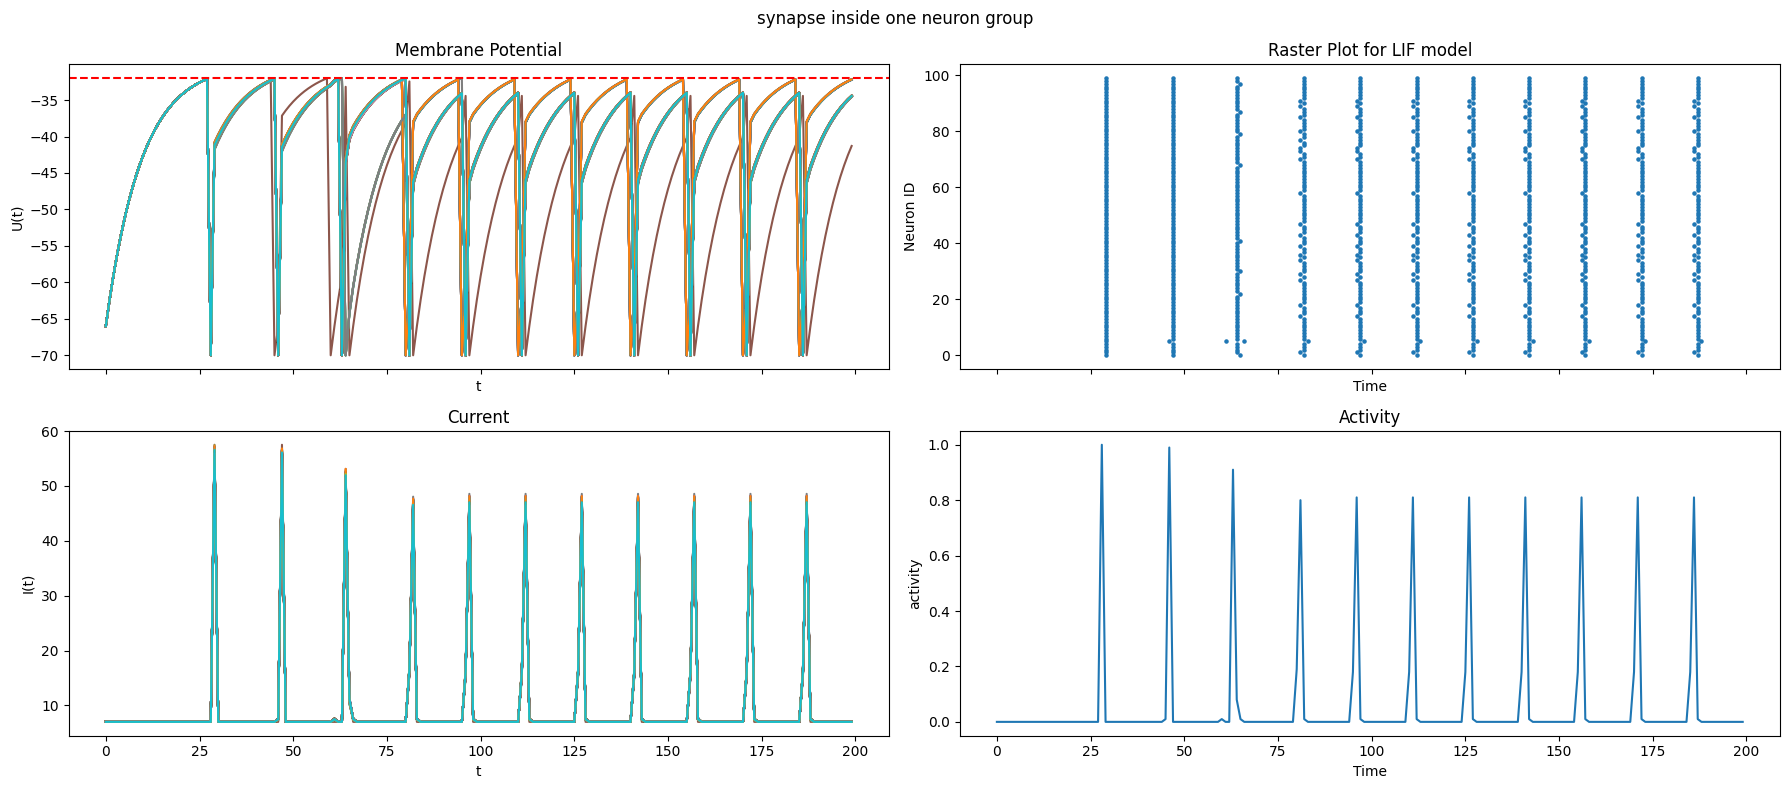

In [4]:
plot_neuron_activity(net, "ng1", "synapse inside one neuron group")

Now we add variance to the initial membrane potential of neurons

In [5]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)

syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop1,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){3:FullyConnectedSynapse(j0=50,variance=0.1,),}
200xBatch: 1/1 (100%) 109.159ms


109.15923118591309

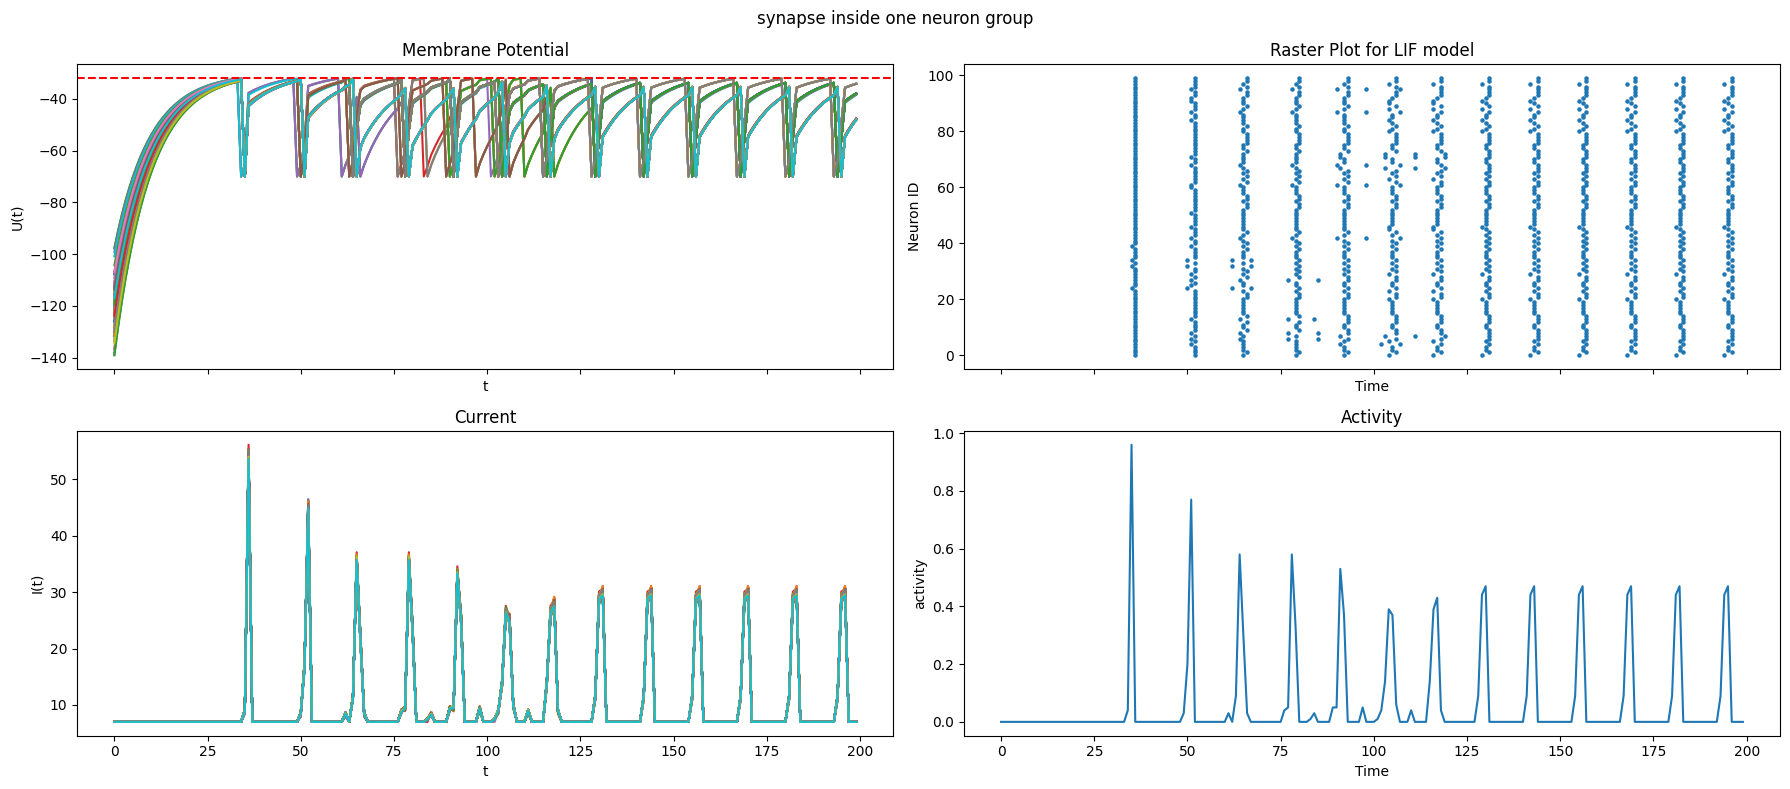

In [6]:
plot_neuron_activity(net, "ng1", "synapse inside one neuron group")

Now we add noises to input current to simulate behaviors more biologically:

In [7]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7,
                           noise_range=1),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)

syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop1,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,noise_range=1,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S100xD100){3:FullyConnectedSynapse(j0=50,variance=0.1,),}
200xBatch: 1/1 (100%) 110.097ms


110.09740829467773

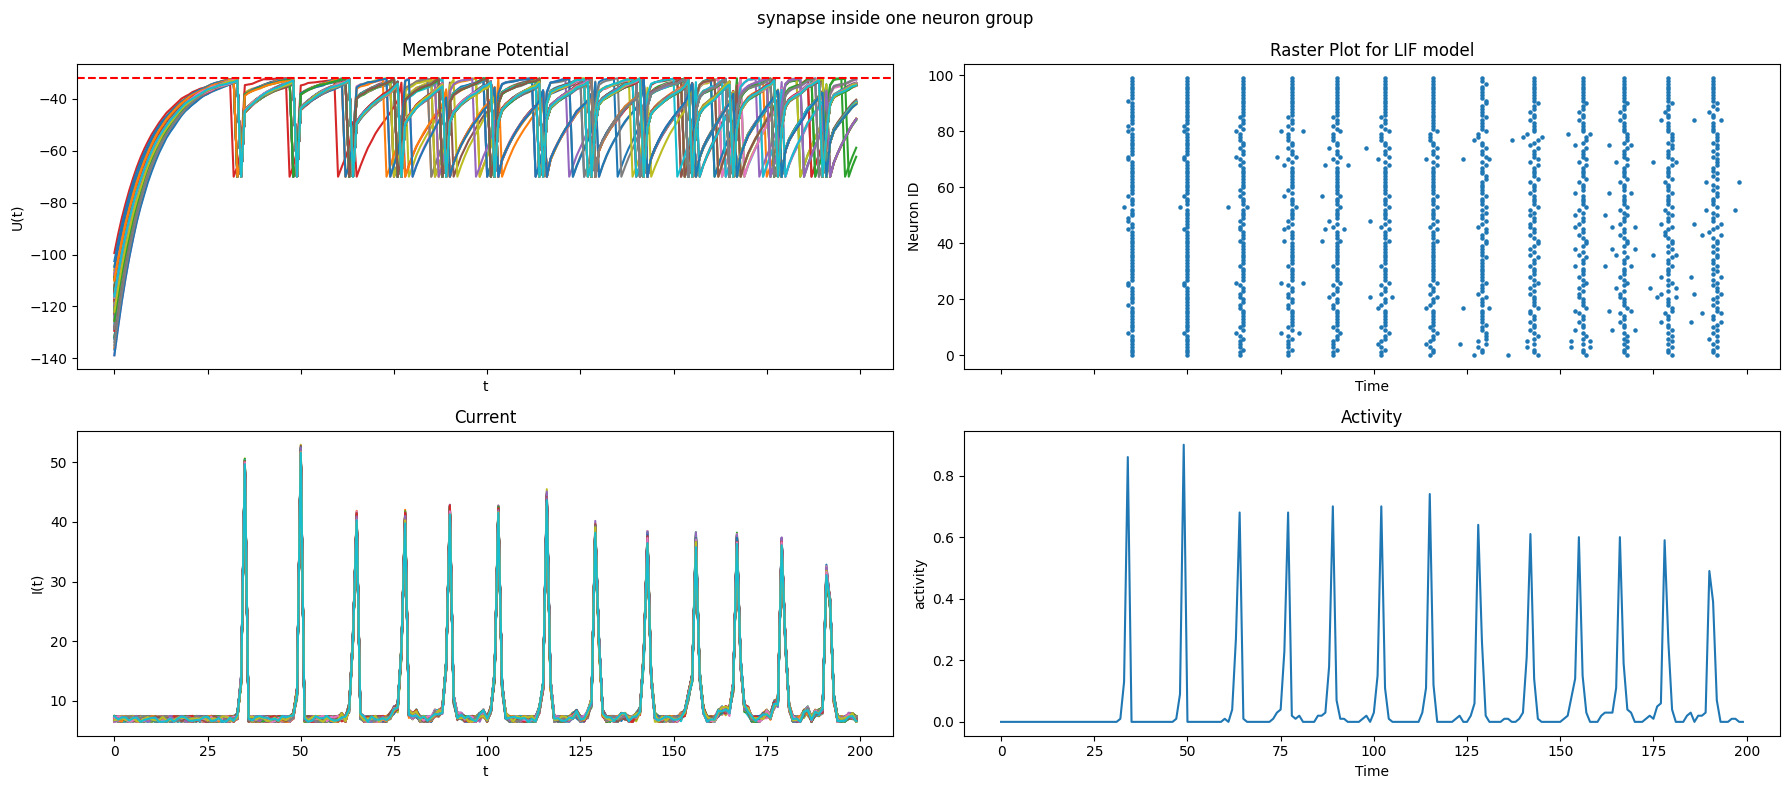

In [8]:
plot_neuron_activity(net, "ng1", "synapse inside one neuron group")

### b) Synapse between two groups:
Now let's create a synapse between two groups of neurons. First, we test when there's no noise and all neurons begin with the same membrane potential.

In [9]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            # v_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=7),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            # v_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD100){3:FullyConnectedSynapse(j0=50,variance=0.1

181.7762851715088

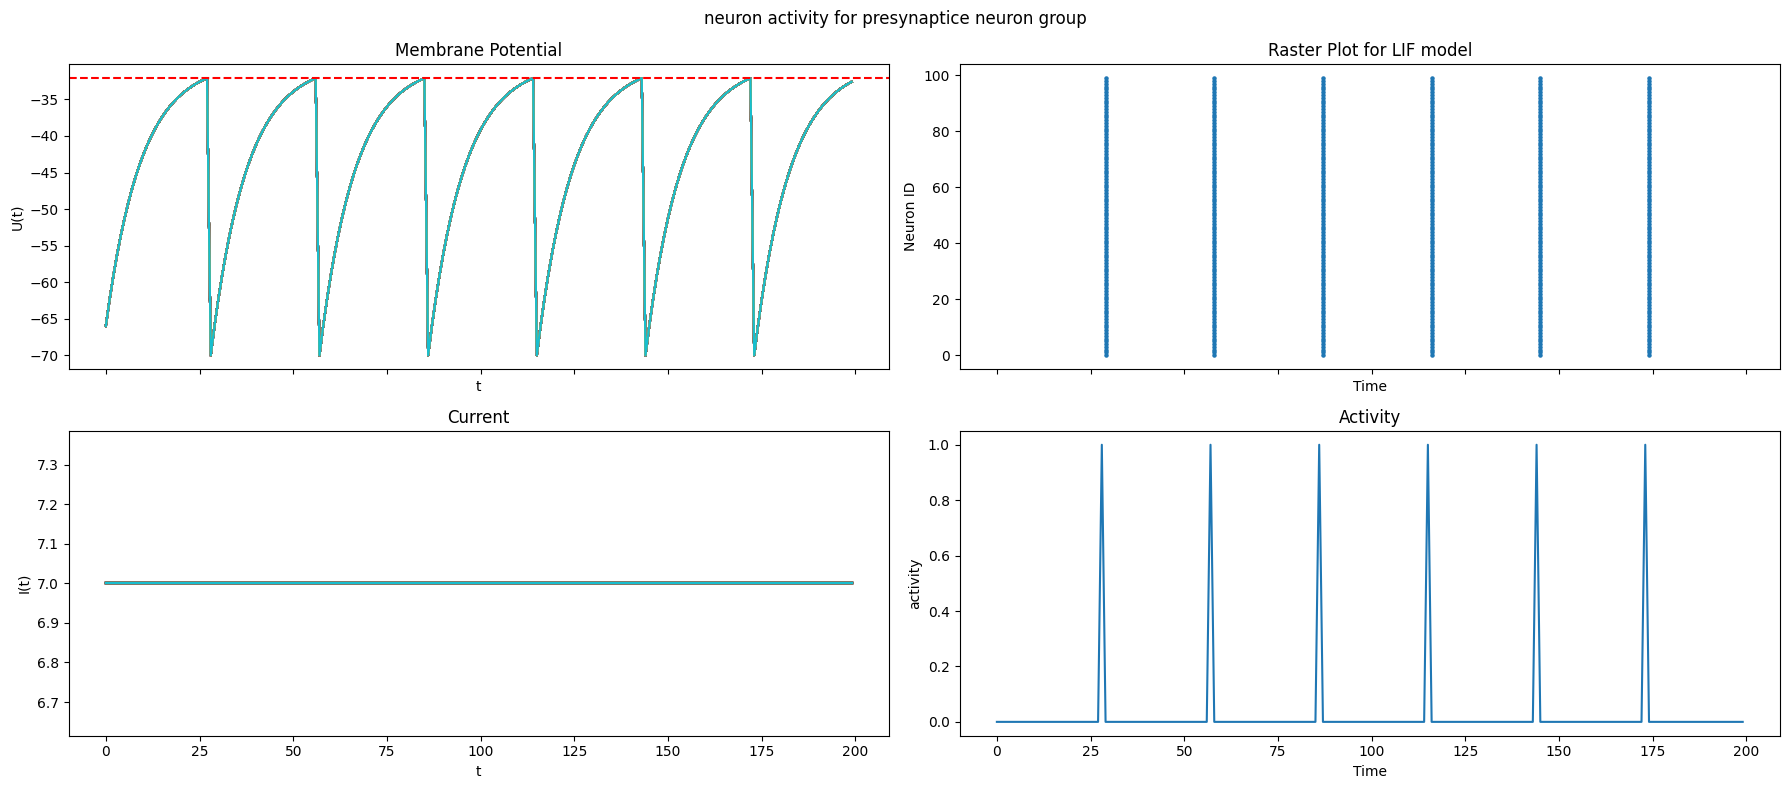

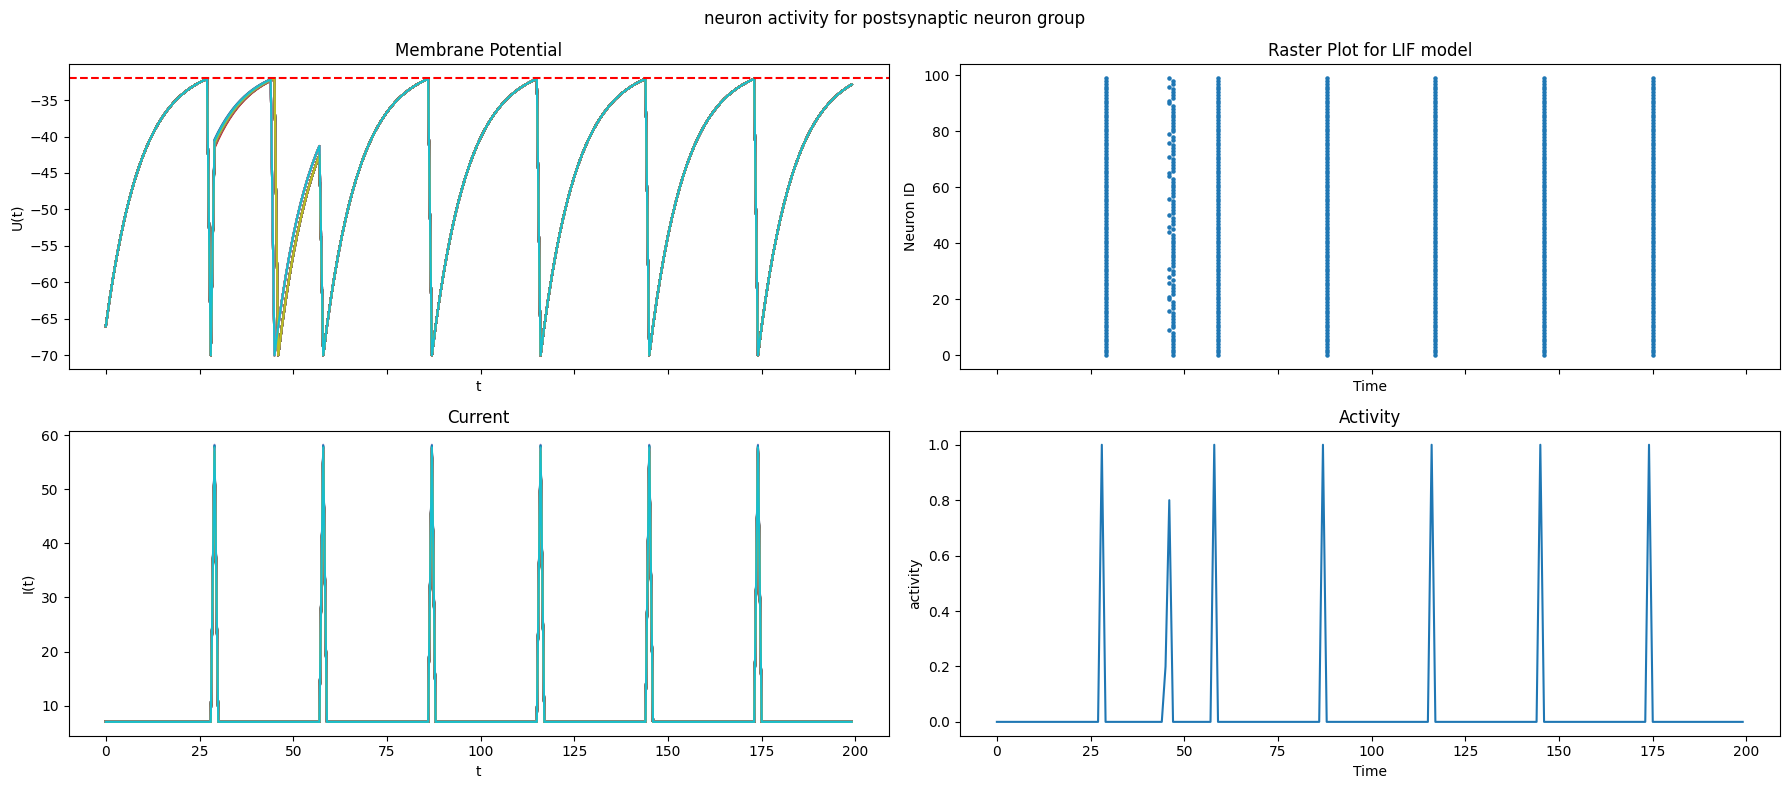

In [10]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptice neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

As we see, when there is no noise and neuron are the same at the beginning, the destination population spikes whenever the source population spikes. Before adding noise and random distribution at initial neuron, let's cut the destination population current and see the results:

In [11]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            # v_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=0),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            # v_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=0,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD100){3:FullyConnectedSynapse(j0=50,variance=0.1

175.84562301635742

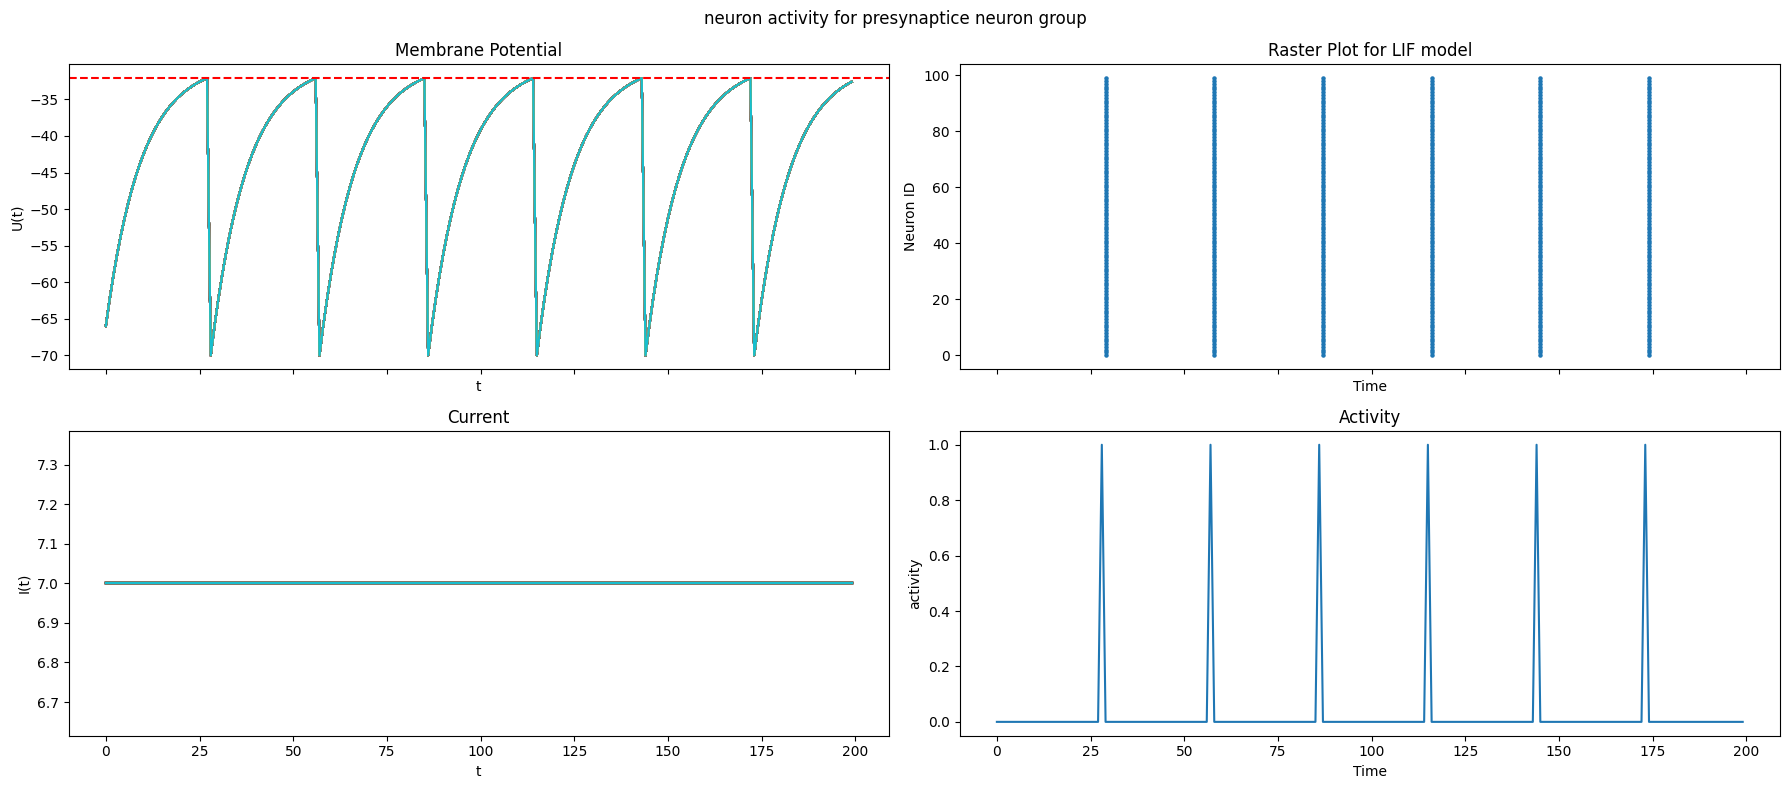

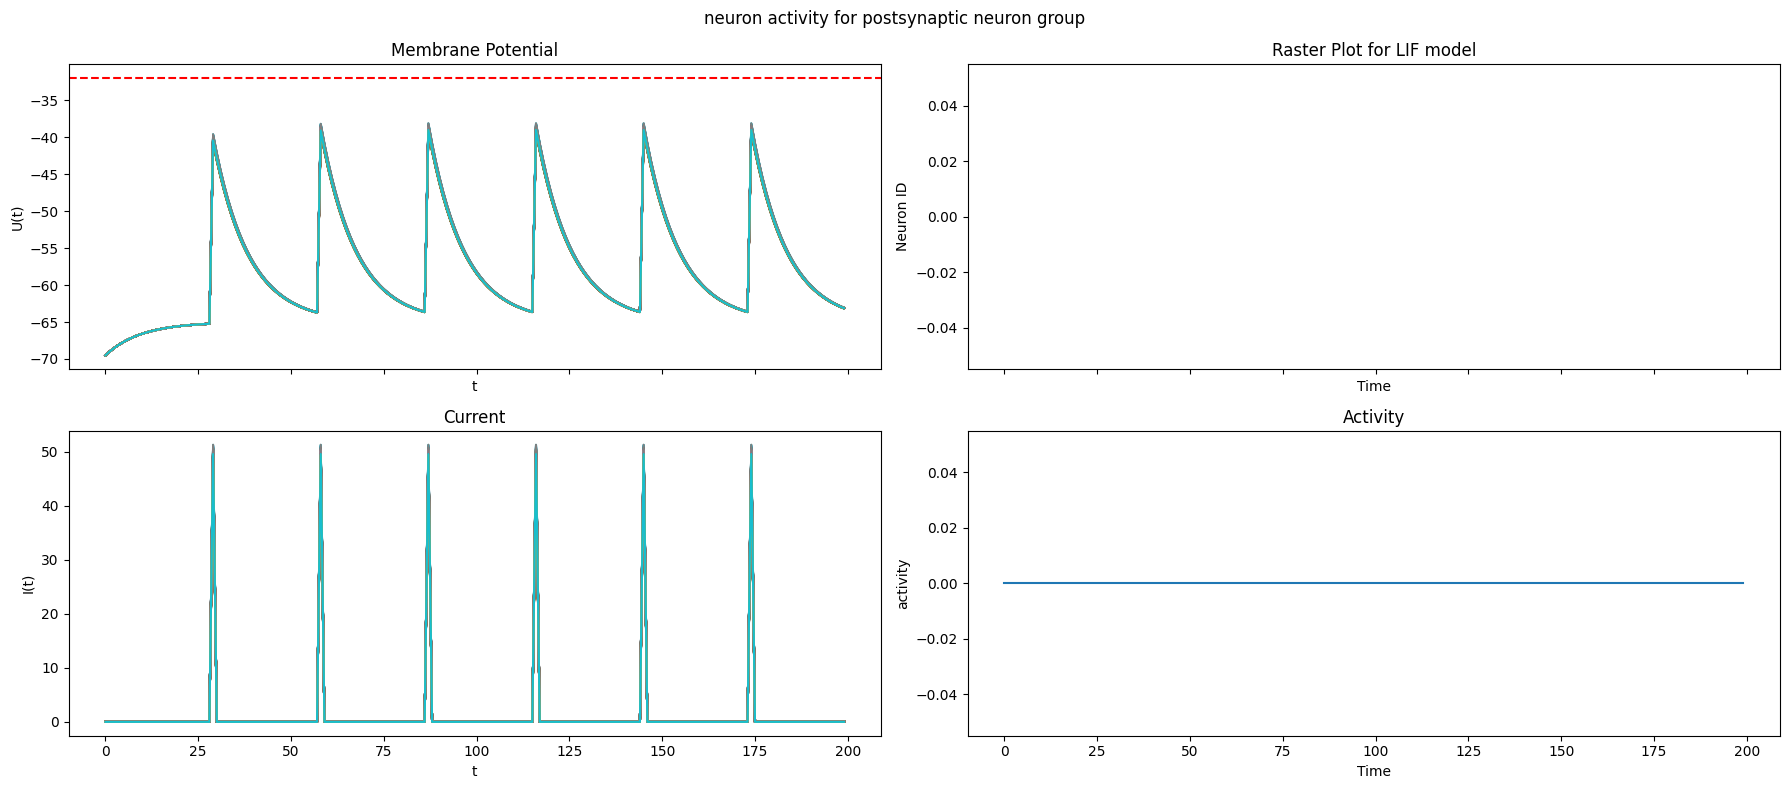

In [12]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptice neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

As we can see, there's no spike for postsynaptic population, it's because the fact that the weights in synapse aren't enough and sum of presynaptic population can't surpass the require current for the postsynaptic population. Now let's increase the mean weight of synapses:

In [13]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            # v_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=0),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            # v_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=80, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=0,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD100){3:FullyConnectedSynapse(j0=80,variance=0.1

196.28119468688965

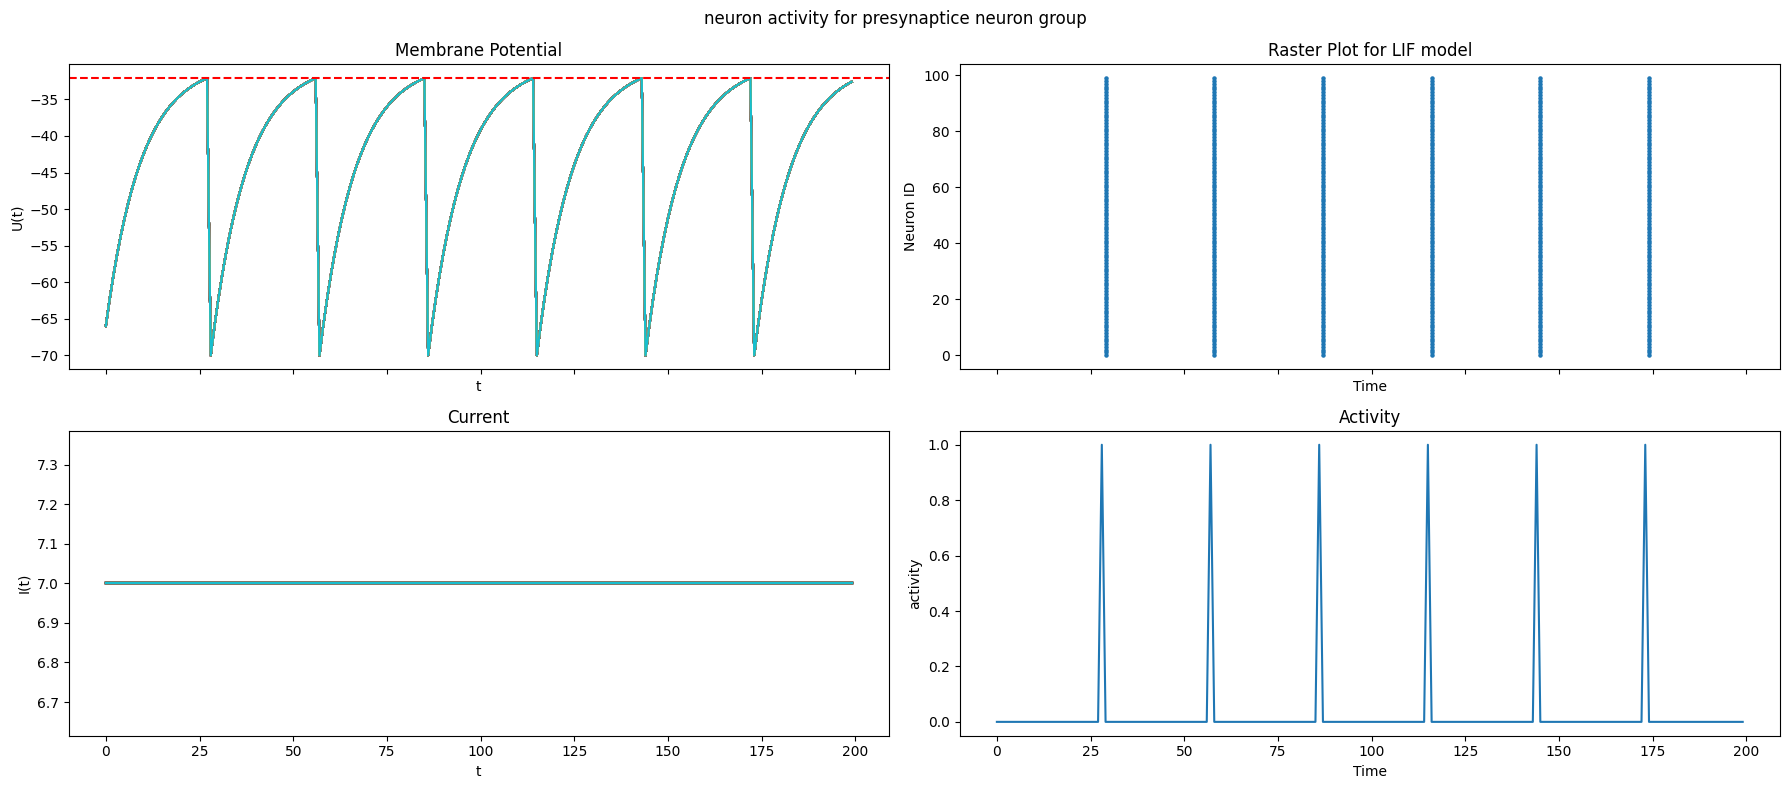

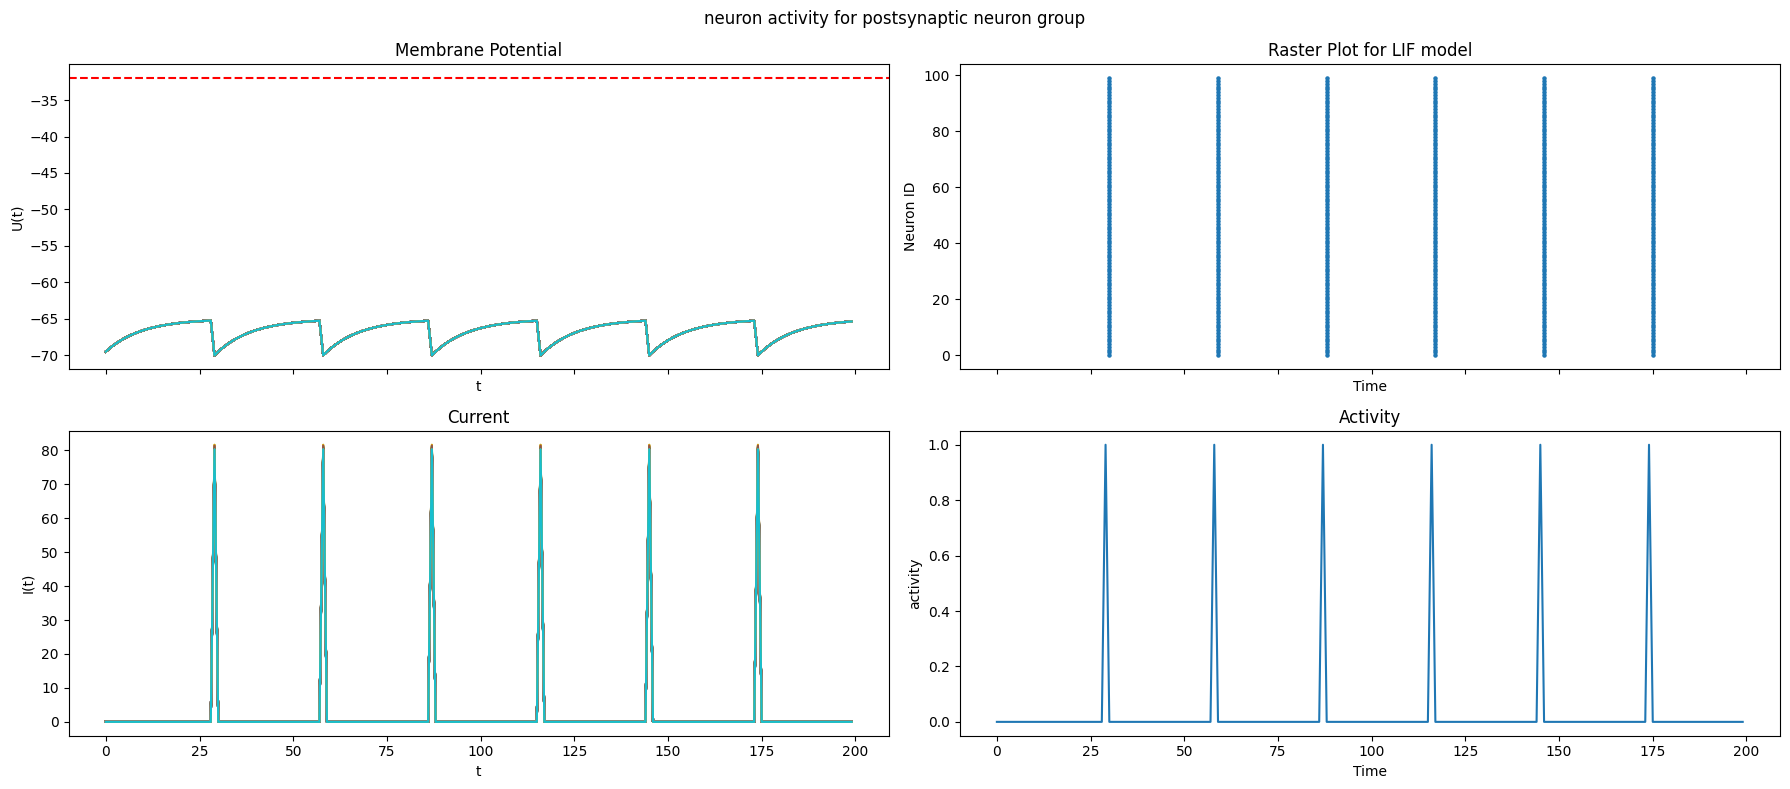

In [14]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptice neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

As we can see, the destination population now spike whenever the source population spikes. NOTE that since the synapse current

Now we change the initial membrane potential of source neurons and see the results:

In [15]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=0),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            # u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=80, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=0,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD100){3:FullyConnectedSyn

201.94435119628906

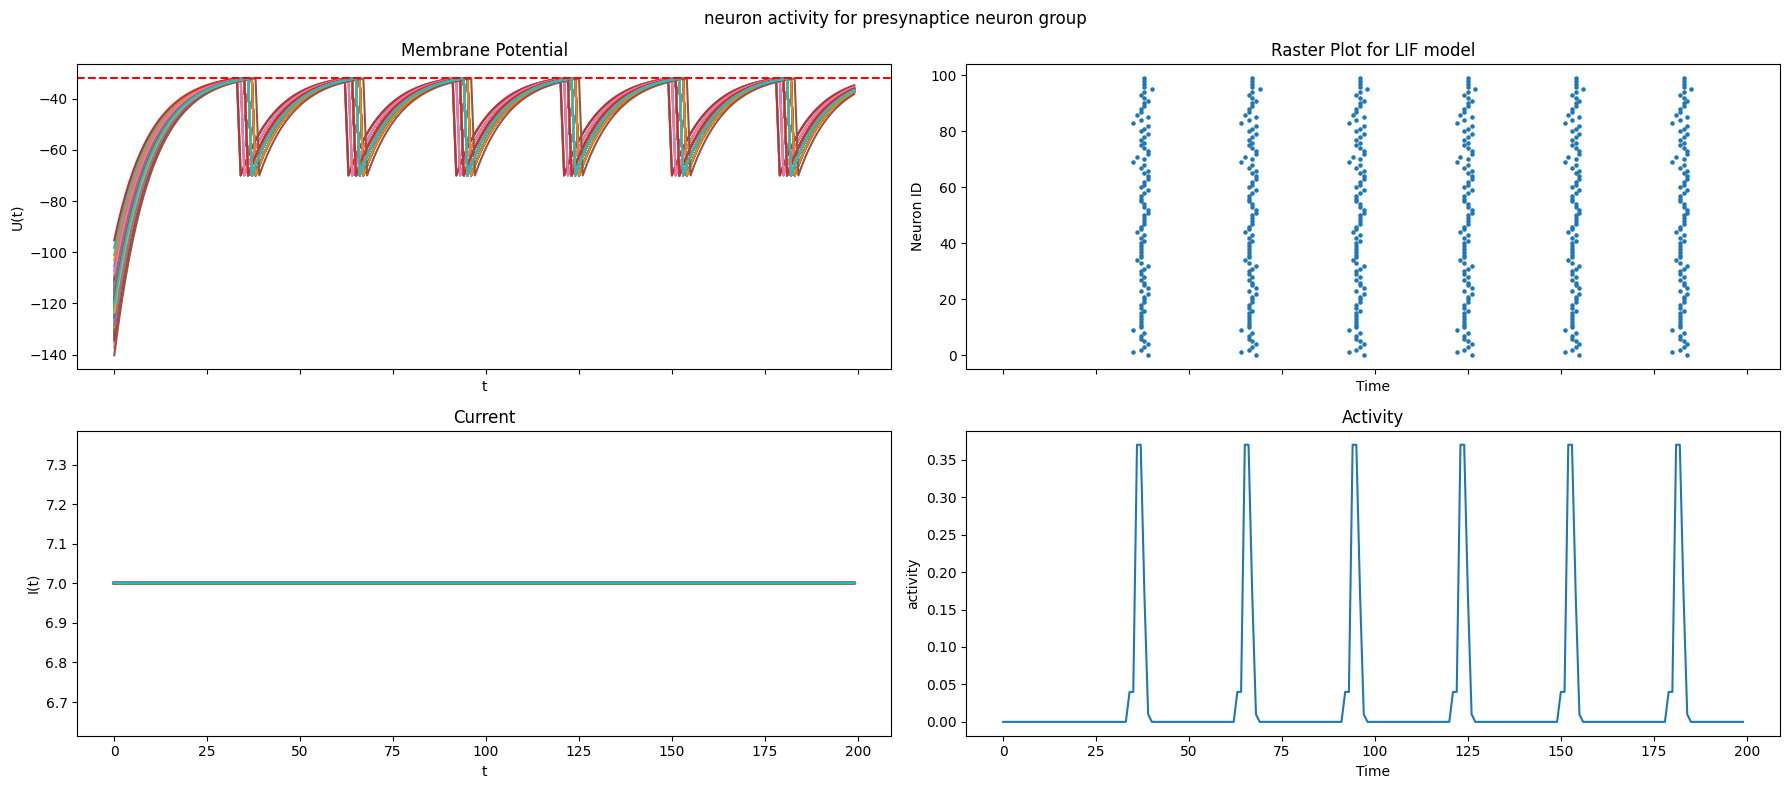

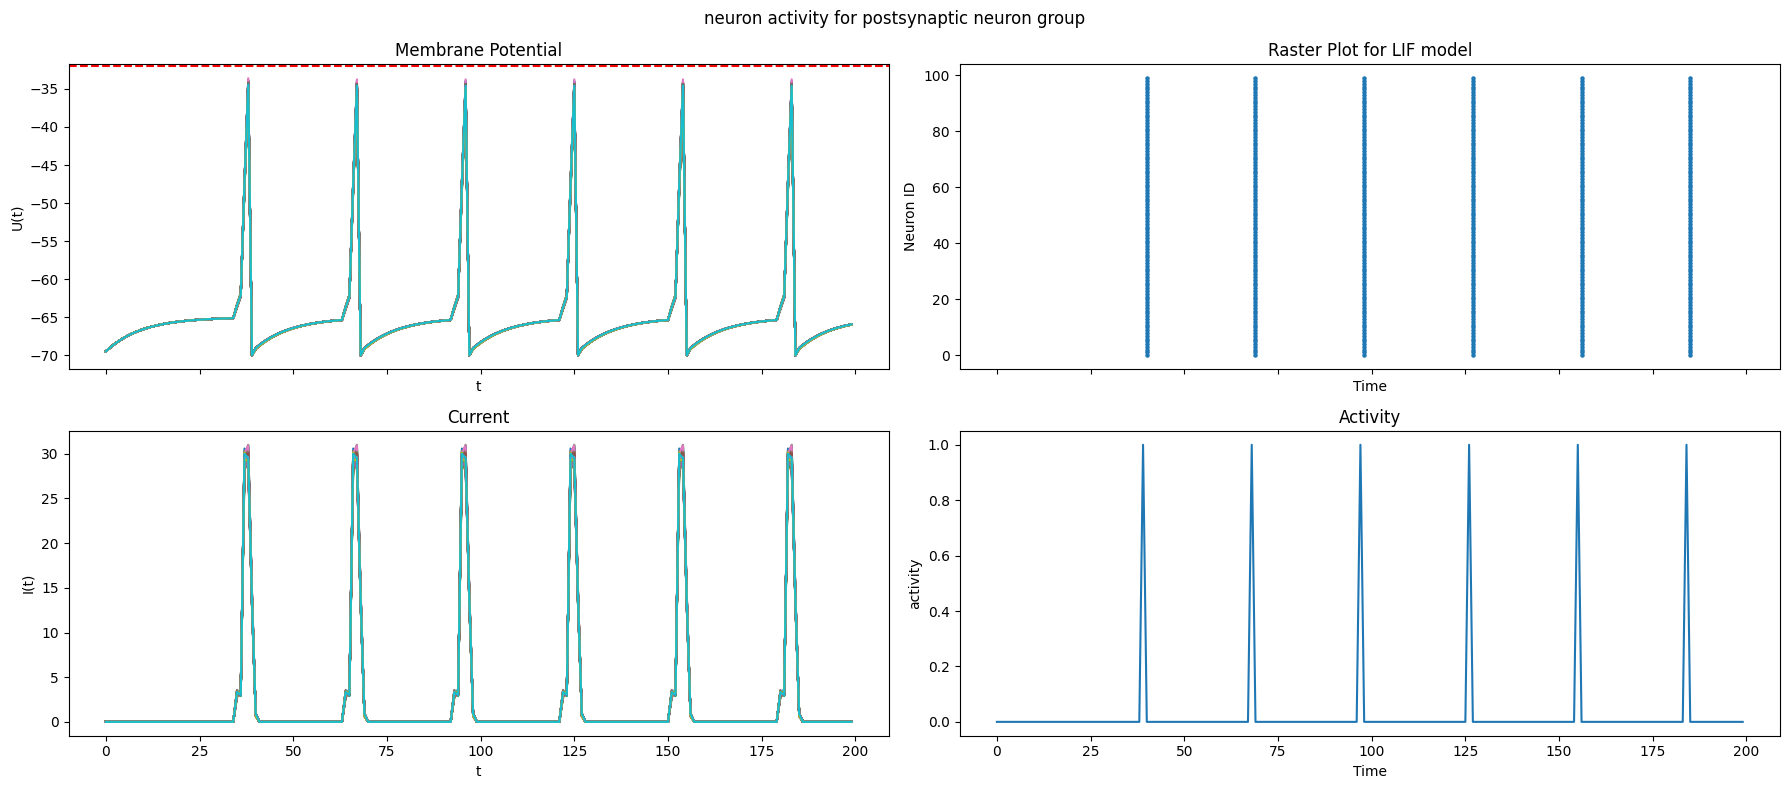

In [16]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptice neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

Now what if we change initial membrane potential of postsynaptic population:

In [17]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=0),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=80, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=0,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD1

188.54141235351562

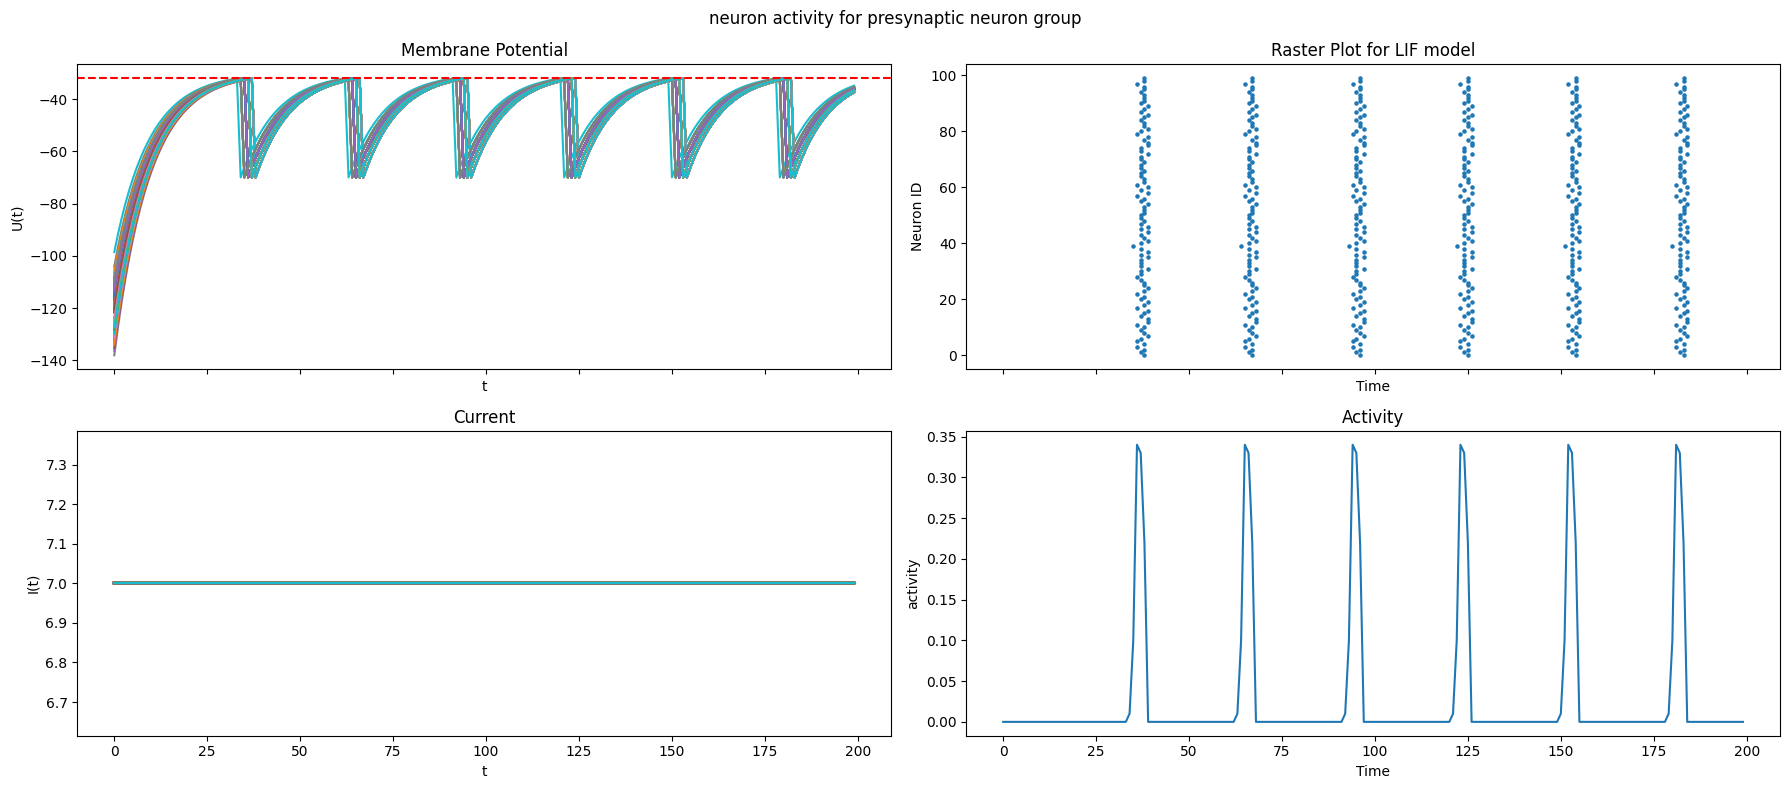

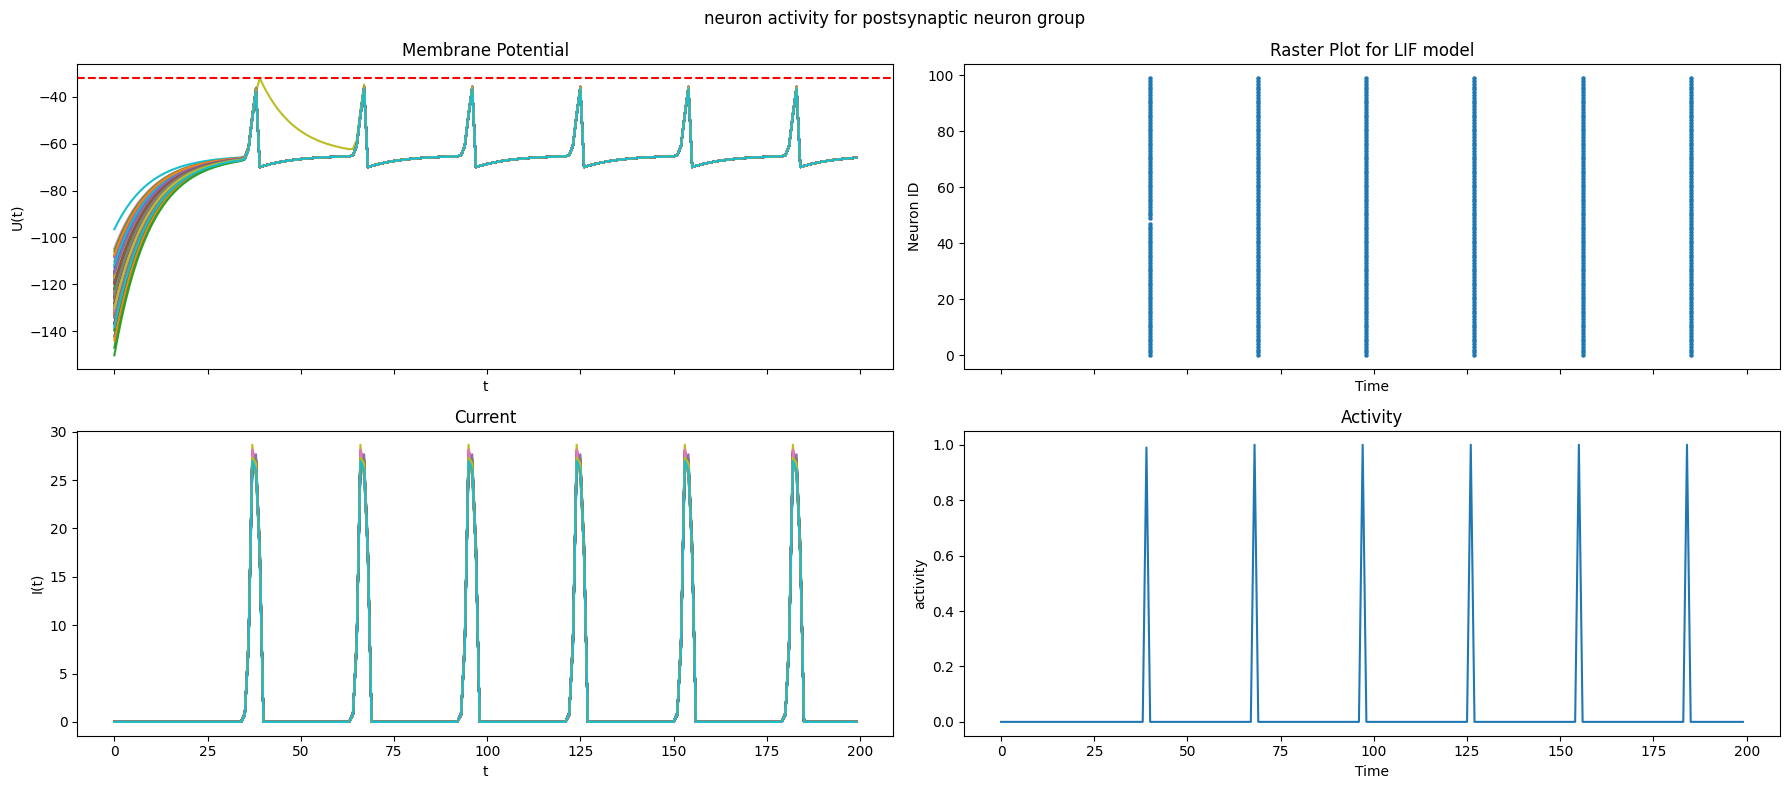

In [18]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptic neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

As we see, postsynaptic population have activity just a little after the activity of presynaptic population with a little more variation.

Now we add the current of postsynaptic population too. Also we decrease the weights to a normal range. The current is near the current of spiking threshold:

In [19]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=7),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_2'](S100xD1

186.79499626159668

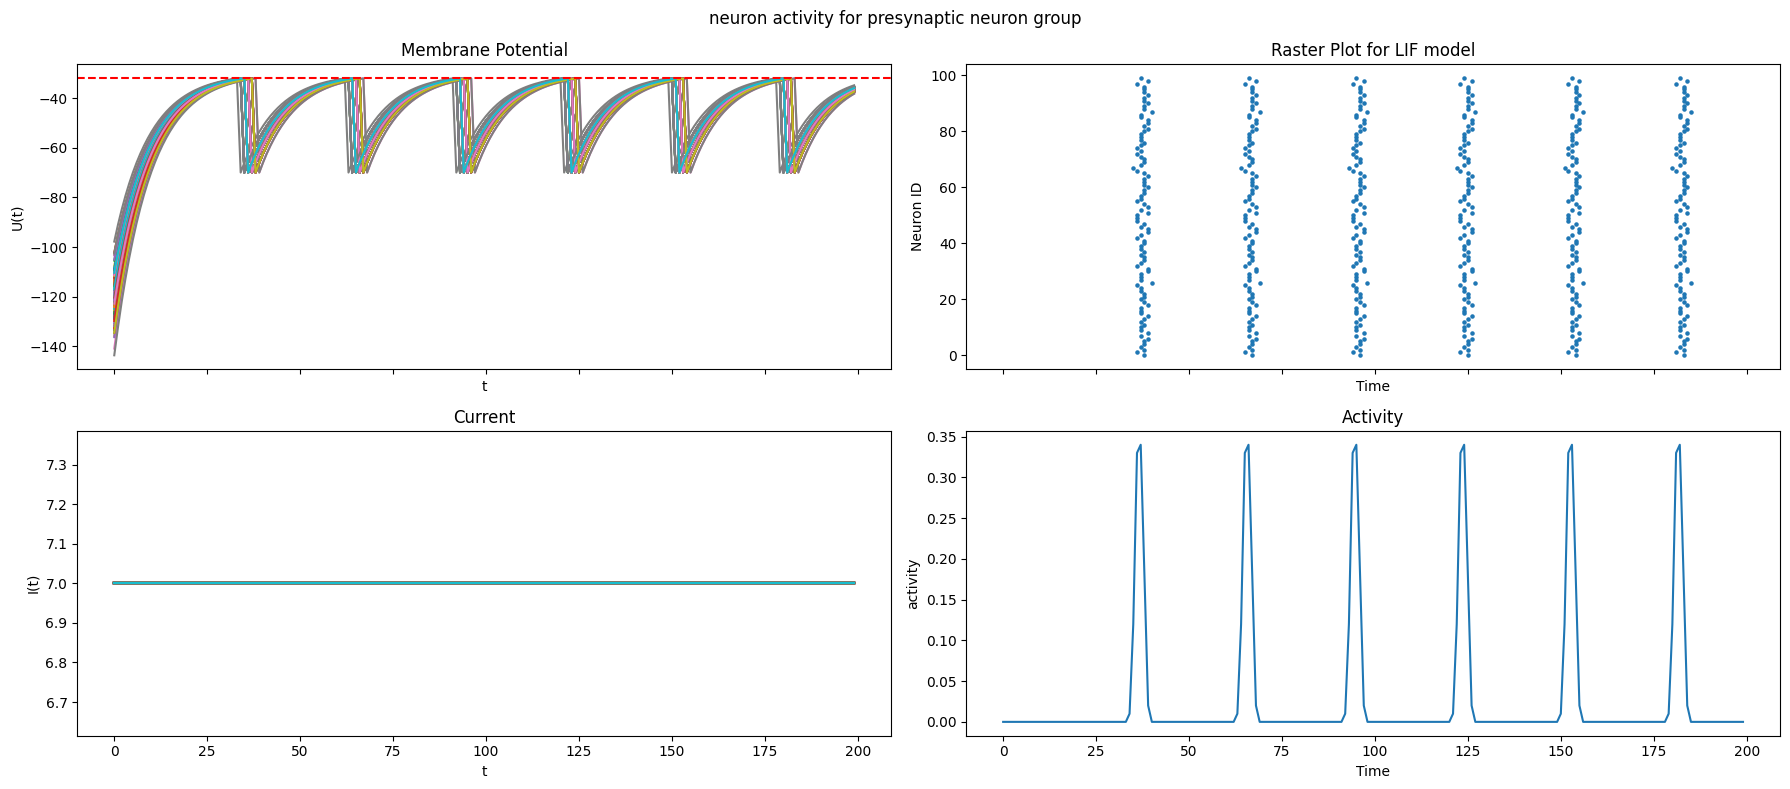

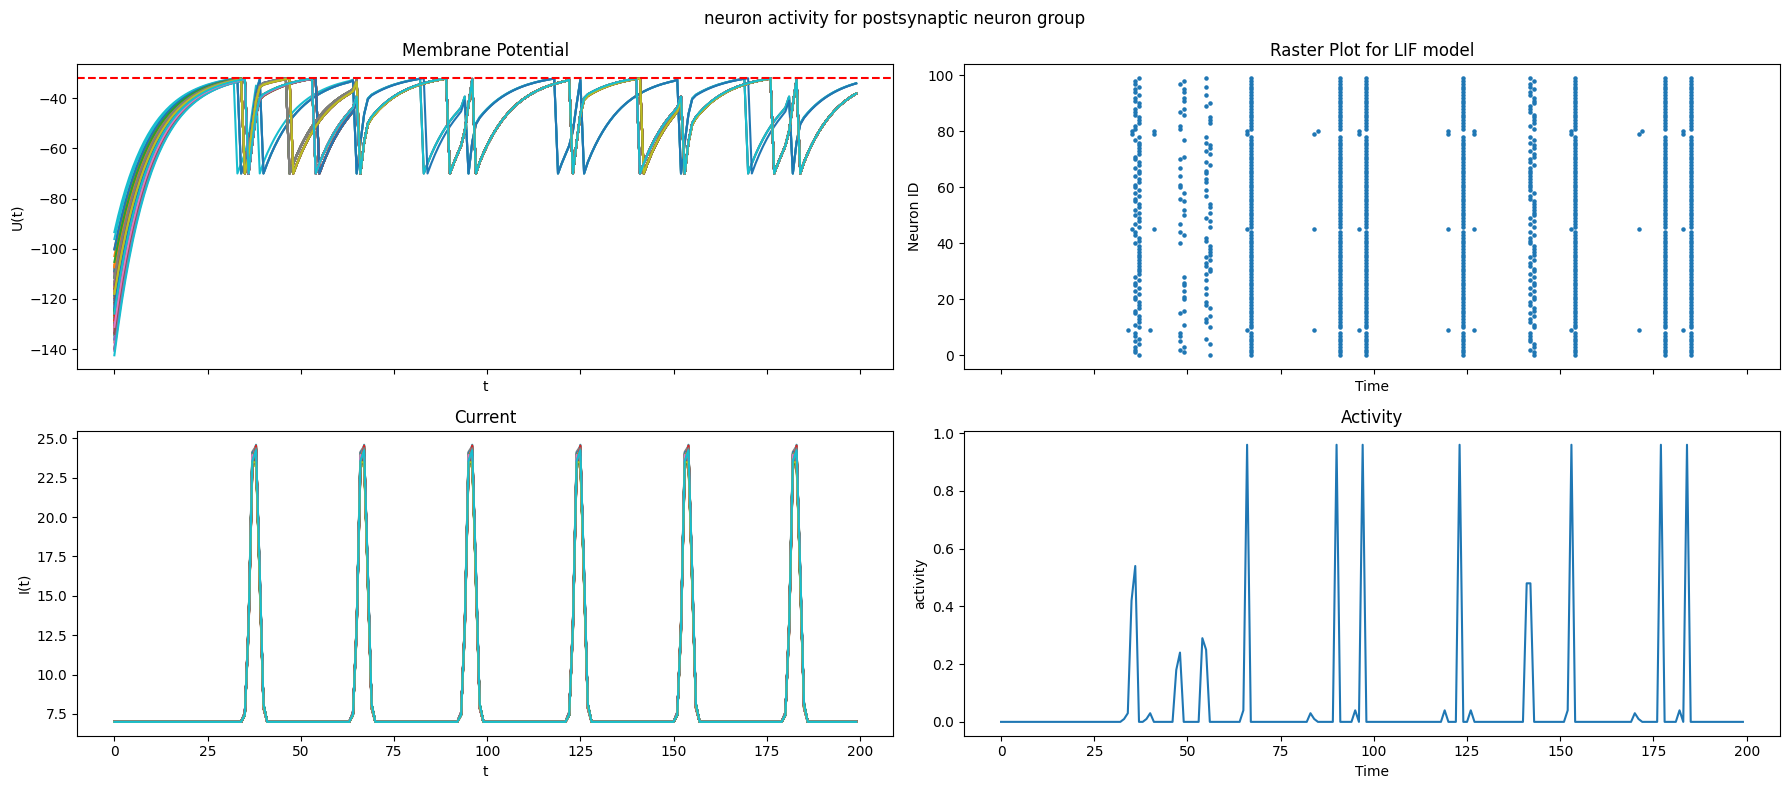

In [20]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptic neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

Now we add noises to the constant current of presynaptic population:

In [21]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7,
                           noise_range=0.5),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=7),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,noise_range=0.5,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronG

182.08837509155273

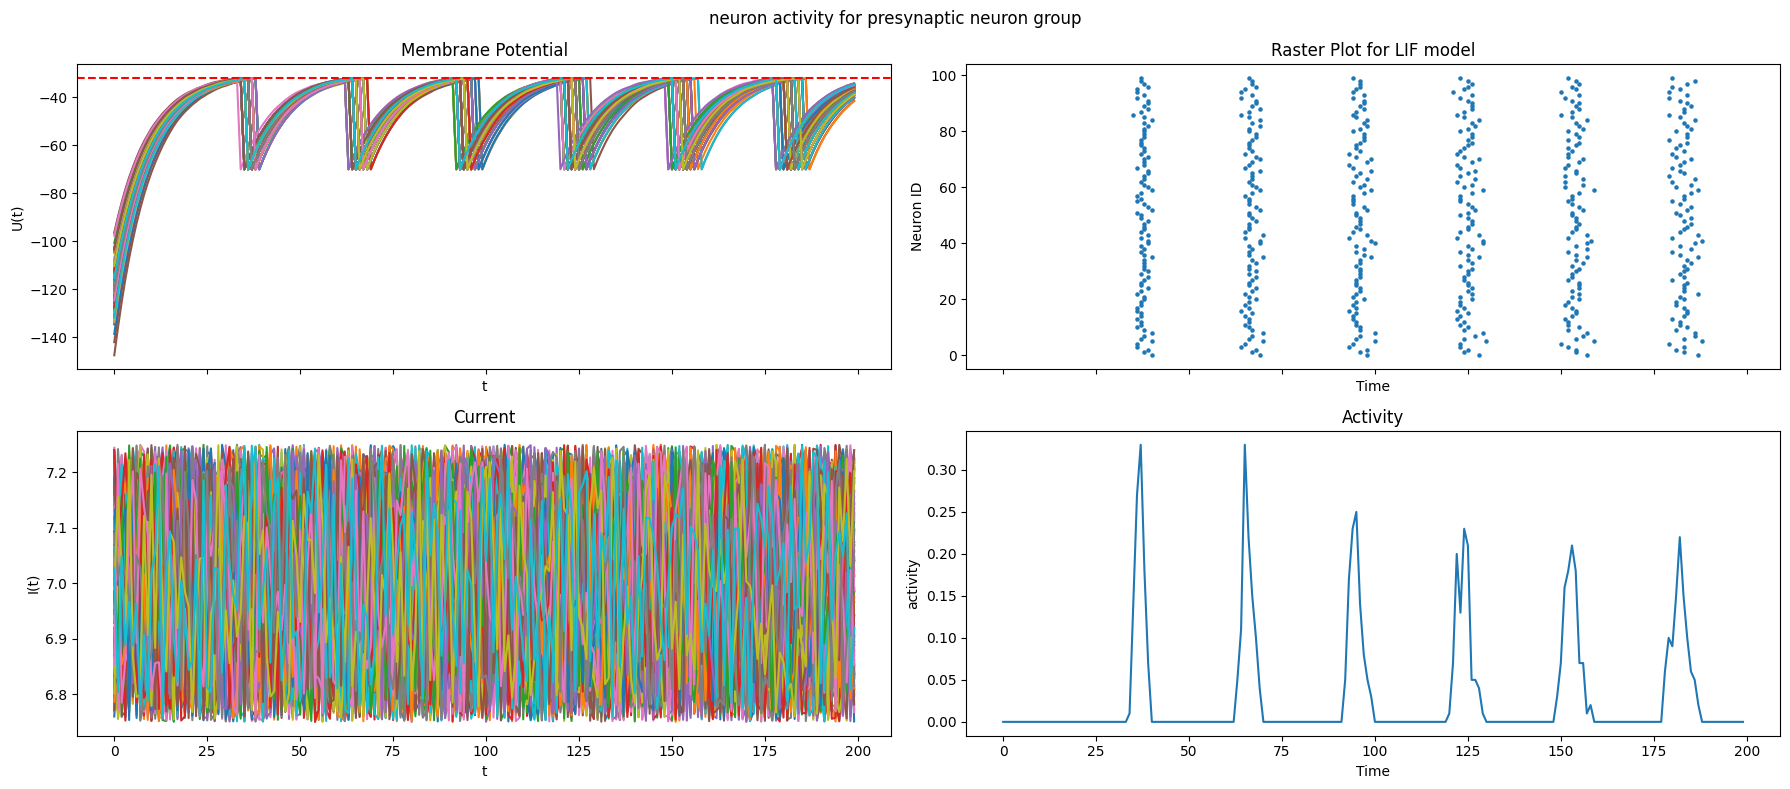

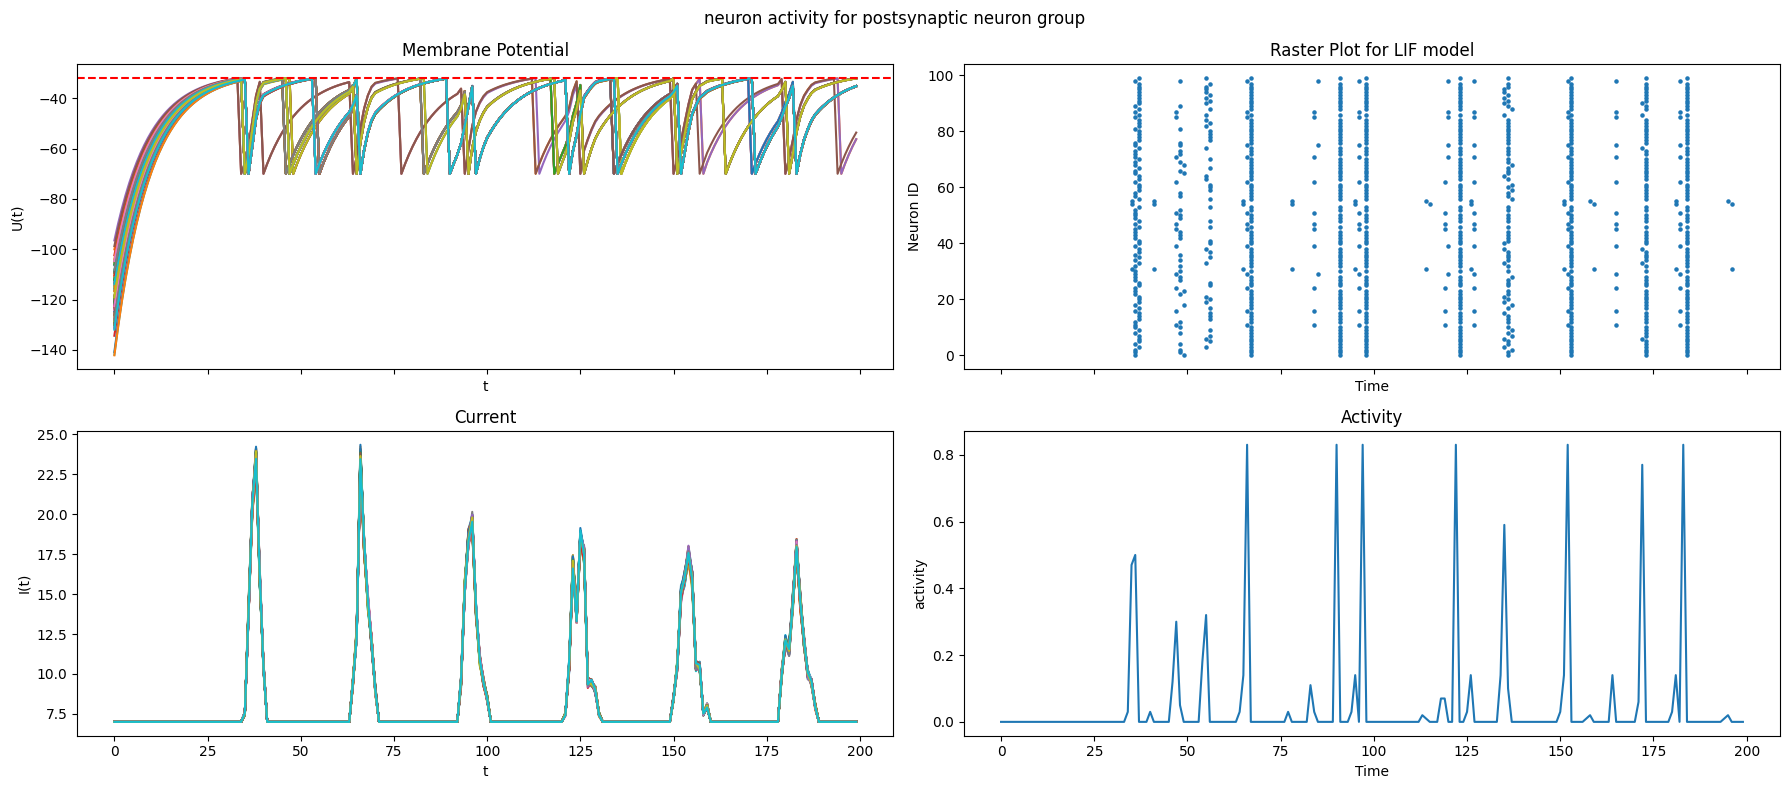

In [22]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptic neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

And if we increase the range a little more:

In [23]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7,
                           noise_range=1),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=7),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,noise_range=1,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGro

169.9962615966797

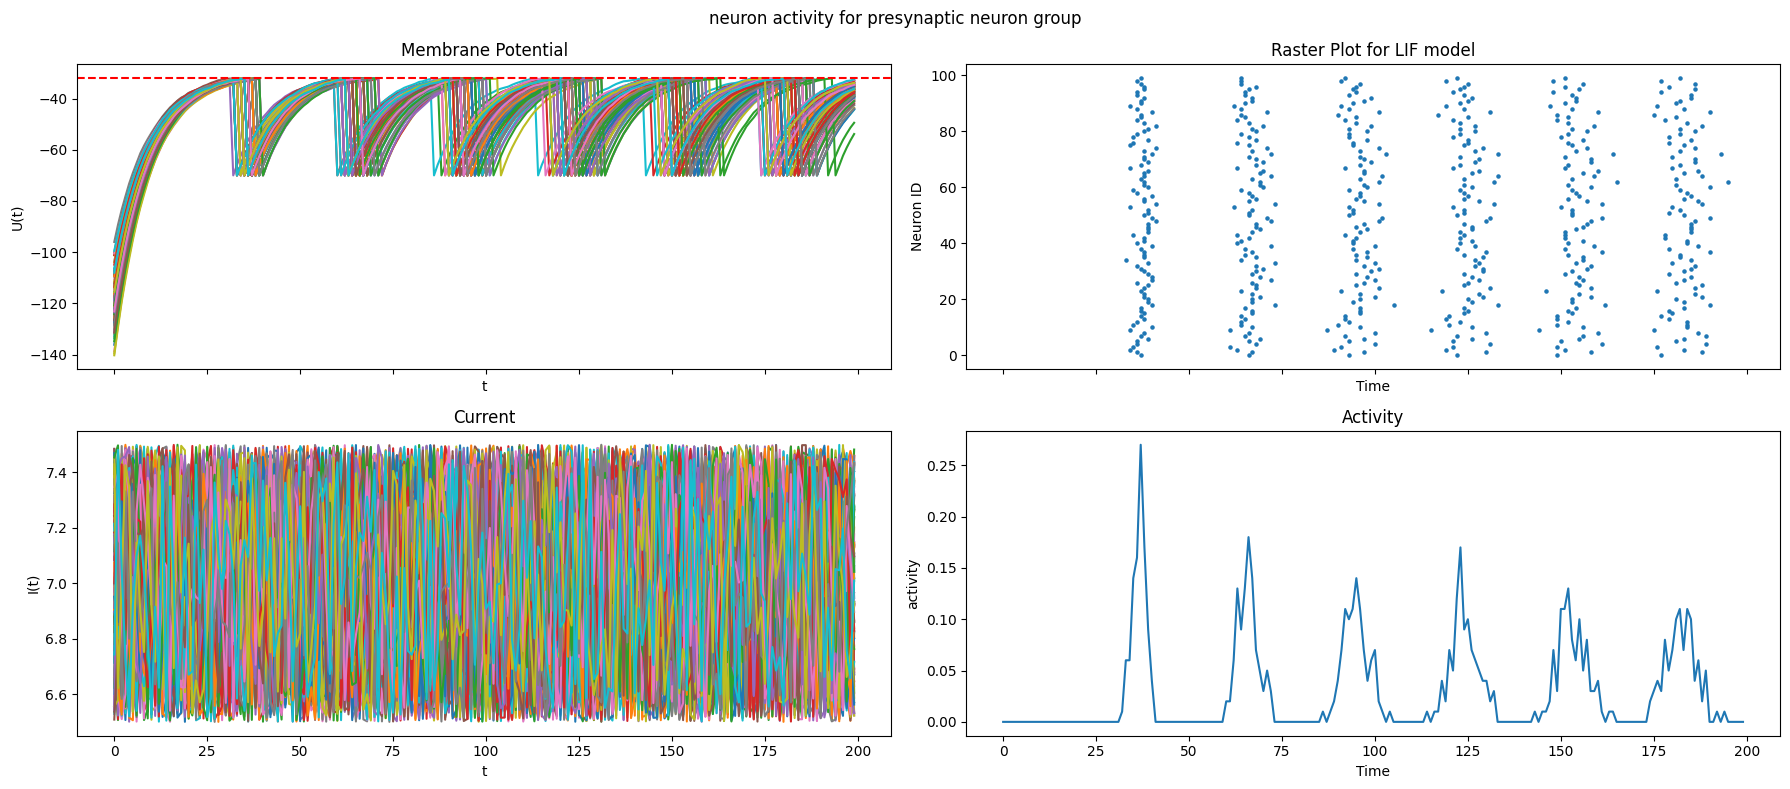

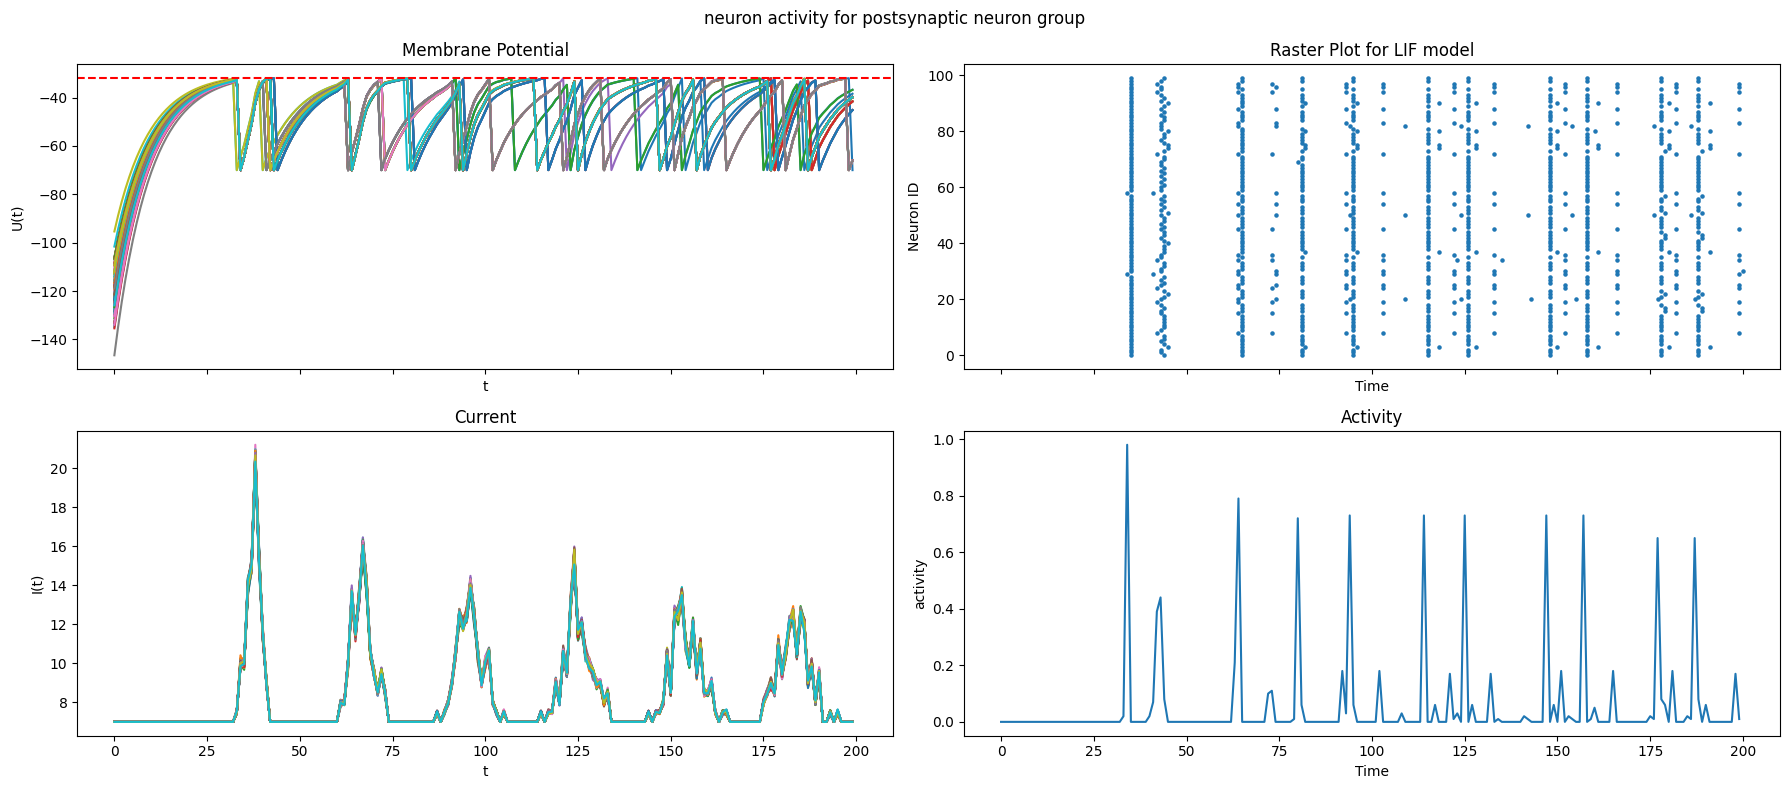

In [24]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptic neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")

And now, to simulate better what happens in real neurons, we add noise to the postsynaptic neurons too:

In [25]:
net = Network(behavior={1: TimeResolution(dt=1.0), })
pop1 = NeuronGroup(
    net=net,
    size=100,
    behavior={
        # 2: SetCurrent(value=100),
        3: ConstantCurrent(value=7,
                           noise_range=1),
        4: Dendrite(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-70,
            threshold=-32,
            R=5,
            u_init="normal(-60, 10)",
        ),
        7: ActivityRecorder(),
        8: Recorder(variables=["u", "I", "activity"], tag="ng1_rec"),
        9: EventRecorder(variables=['spike'], tag="ng1_event")
    }
)
pop2 = NeuronGroup(
                    net=net,
                    size=100,
                    behavior={
                        # 2: SetCurrent(value=100),
                        3: ConstantCurrent(value=7,
                                           noise_range=1),
                        4: Dendrite(),
                        5: LIF(
                            tau=10,
                            u_rest=-65,
                            u_reset=-70,
                            threshold=-32,
                            R=5,
                            u_init="normal(-60, 10)",
                        ),
                        7: ActivityRecorder(),
                        8: Recorder(variables=["u", "I", "activity"], tag="ng2_rec"),
                        9: EventRecorder(variables=['spike'], tag="ng2_event")
                    }
                )
syn = SynapseGroup(net=net,
                   tag="All",
                   src=pop1,
                   dst=pop2,
                   behavior={3: FullyConnectedSynapse(j0=50, variance=0.1)})

net.initialize()
net.simulate_iterations(iterations=200)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(10000)|1 groups){1:TimeResolution(dt=1.0,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,noise_range=1,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_event,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](100){3:ConstantCurrent(value=7,noise_range=1,)4:Dendrite()5:LIF(tau=10,u_rest=-65,u_reset=-70,threshold=-32,R=5,u_init=normal(-60, 10),)7:ActivityRecorder()8:Recorder(variables=['u', 'I', 'activity'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_rec,)9:EventRecorder(variables=['spike'],gap_width=0,max_length=None,auto_annotate=True,tag=ng2_event,)}
SynapseGroup['All', 'SynapseGroup', 'syn', 'NeuronGroup_

176.45263671875

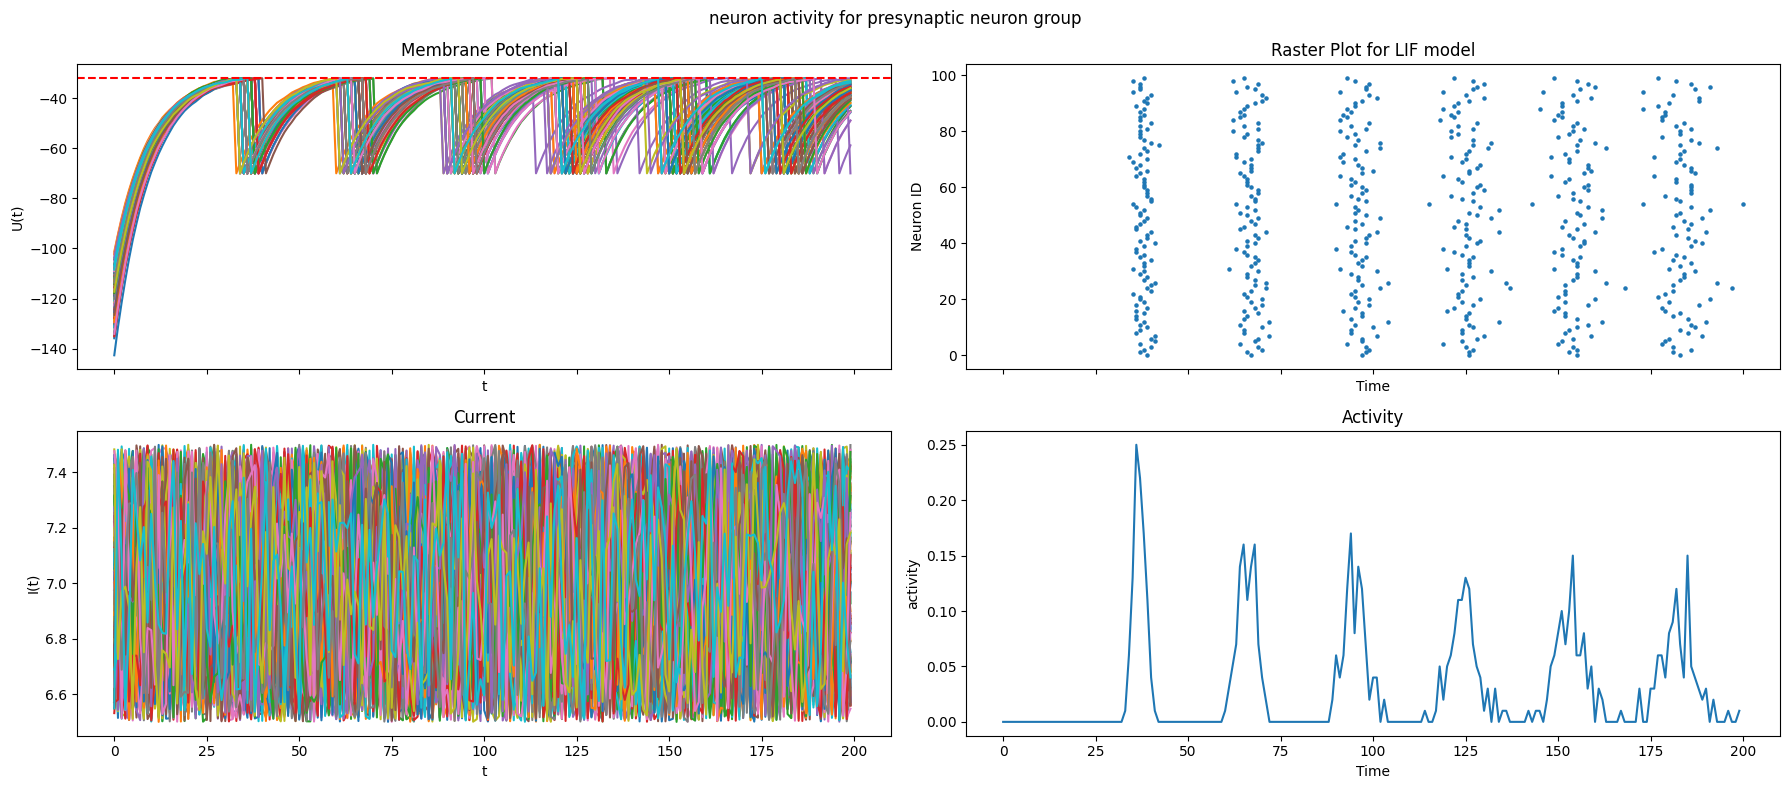

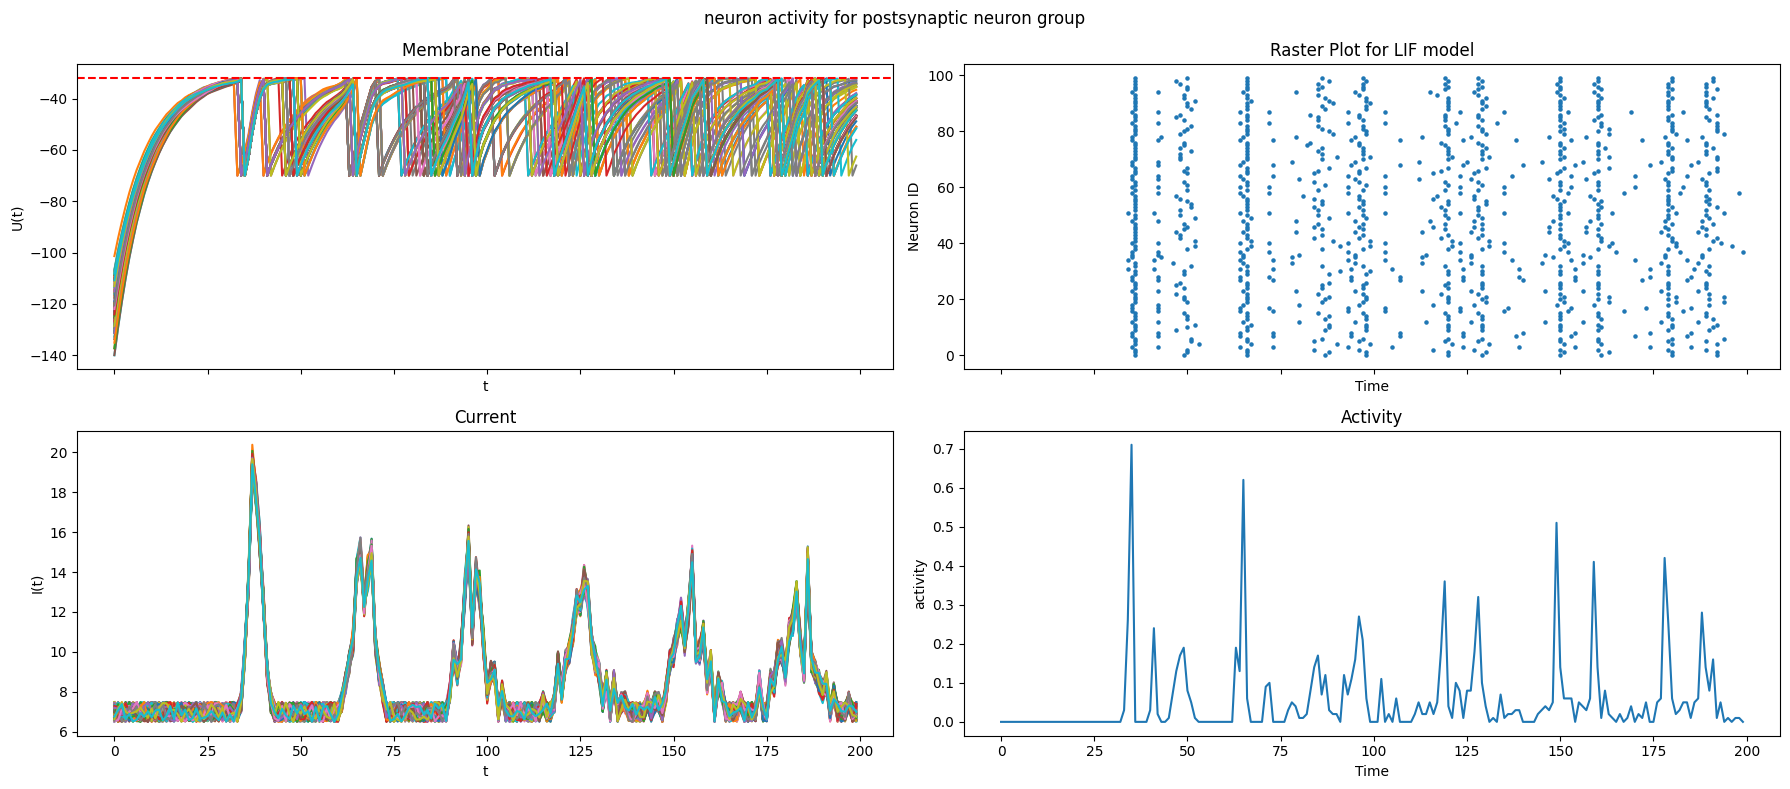

In [26]:
plot_neuron_activity(net, "ng1", "neuron activity for presynaptic neuron group")
plot_neuron_activity(net, "ng2", "neuron activity for postsynaptic neuron group")